In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib as mpl

## 01 Import data

In [2]:
prices = pd.read_csv("../data/sp500_stocks.csv")
idx = pd.read_csv("../data/sp500_index_updated.csv", usecols=['Date', 'Adj Close'])

In [3]:
seed = 42

In [4]:
print(f"Number of constituent companies: {prices.Symbol.unique().shape}")
print(f"Number of years of data: {prices.Date.unique().shape[0] / 252:.2f}")
print(f"Start: {prices.Date.min()}")
print(f"End: {prices.Date.max()}")

Number of constituent companies: (503,)
Number of years of data: 14.74
Start: 2010-01-04
End: 2024-10-04


## 02 Helper functions

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, normalize
from scipy import stats
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

In [6]:
def get_beta(stock, market):
    X = market.values.reshape(-1, 1)
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(stock.values)
    return b[1]

def apply_beta_per_year(group):
    t = group['spx']
    betas = {}
    for stock in group.columns:
        s = group[stock]
        betas[stock] = get_beta(s, t)
    return pd.Series(betas, name=group.index[-1])

In [7]:
def get_scaled_data(data):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data

def get_pca_data(df, n_components, show_plot=False, title=''):
    scaled_data = get_scaled_data(df)
    pca = PCA(n_components=5)
    pca_data = pca.fit_transform(scaled_data)
    print(f"pca_data shape: {pca_data.shape}")
    print(f"explained var: {pca.explained_variance_ratio_}")
    print(f"singular values: {pca.singular_values_}")
    
    if show_plot:
        plt.scatter(pca_data[:,0], pca_data[:,1], alpha=0.5, s=5)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        if title:
            plt.title(title)
        plt.show()

        fig = plt.figure(figsize = (8, 6))
        ax = plt.axes(projection ="3d")
        ax.scatter3D(pca_data[:,0], pca_data[:,1], pca_data[:,2], alpha=0.5, s=5)
        plt.xlabel('pc1')
        plt.ylabel('pc2')
        if title:
            plt.title(title)
        plt.show()
    
    return pca_data

def get_tsne_data(df, perplexity, n_components=2, scaled=True, show_plot=False, title=''):
    if scaled:
        scaled_data = get_scaled_data(df)
    else:
        scaled_data = df.values
    tsne_data = TSNE(n_components=n_components, perplexity=perplexity, random_state=seed).fit_transform(scaled_data)
    
    if show_plot:
        plt.scatter(tsne_data[:,0], tsne_data[:,1], alpha=0.5, s=5)
        plt.xlabel('dim1')
        plt.ylabel('dim2')
        if title:
            plt.title(title)
        plt.show()

        if n_components > 2:
            fig = plt.figure(figsize = (8, 6))
            ax = plt.axes(projection ="3d")
            ax.scatter3D(tsne_data[:,0], tsne_data[:,1], tsne_data[:,2], alpha=0.5, s=5)
            plt.xlabel('dim1')
            plt.ylabel('dim2')
            if title:
                plt.title(title)
            plt.show()
    
    return tsne_data

def get_kmeans_score(data):
    measures = ['silhouette', 'davies', 'calinski', 'inertia']
    m_func = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    init_methods = ['k-means++', 'random']
    x_range = np.arange(2, 21)
    
    scores = {i: {m: [] for m in measures} for i in init_methods}
    for k in tqdm(x_range):
        for init in init_methods:
            model = KMeans(n_clusters=k, random_state=seed, init=init).fit(data)
            labels = model.labels_
            for (m, f) in zip(measures[:-1], m_func):
                scores[init][m].append(f(data, labels))
            scores[init]['inertia'].append(model.inertia_)
                        
    return scores


In [8]:
def get_gmm_score(data):
    measures = ['silhouette', 'davies', 'calinski']
    m_func = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    init_methods = ["kmeans", "random"]
    x_range = np.arange(2, 21)
    
    scores = {i: {m: [] for m in measures} for i in init_methods}
    for k in tqdm(x_range):
        for init in init_methods:
            labels = GaussianMixture(n_components=k, init_params=init, random_state=seed).fit_predict(data)
            for (m, f) in zip(measures, m_func):
                scores[init][m].append(f(data, labels))
                        
    return scores

def plot_gmm_score(scores):
    title_mapper = {
        'silhouette': 'Silhouette Score',
        'davies': 'Davies-Bouldin Index',
        'calinski': 'Calinski and Harabasz Index',
    }
    inits = ['kmeans', "random"]
    scorings = ['silhouette', 'davies', 'calinski']

    f, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
    x_range = range(2, 21)

    for init in inits:
        for a, m in enumerate(scorings):
            axes[a].plot(x_range, scores[init][m], label=init, marker='o')
            axes[a].set_title(title_mapper[m])
            if len(inits) > 1:
                axes[a].legend()
            axes[a].set_xticks(x_range)
            axes[a].set_xlabel('K value')

def compare_init_methods(data, k=3):
    f, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
    init_methods = ['kmeans', "random"]
    for i, init in enumerate(init_methods):
        start = time.time()
        gmm = GaussianMixture(n_components=k, init_params=init, random_state=seed)
        y_pred = gmm.fit_predict(data)
        total = time.time() - start
        centroids = gmm.means_
        num_iters = gmm.n_iter_
        axes[i].scatter(data[:,0], data[:,1], c=y_pred, alpha=0.5, s=10, cmap='viridis')
        axes[i].scatter(centroids[:,0], centroids[:,1], c=[i for i in range(k)], marker='s', s=80, edgecolors='black', linewidth=1)
        axes[i].set_title(f'{init}   {total:.5f}s Iter {num_iters}')

def make_ellipses(gmm, ax):
    for n, color in enumerate(["navy", "turquoise", "darkorange"]):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.2)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")
        
def compare_cov_methods(data, k=3):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
    cov_methods = ["spherical", "diag", "tied", "full"]
    for a, cov_method in enumerate(cov_methods):
        gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=seed, covariance_type=cov_method)
        y_pred = gmm.fit_predict(data)
        i = a // 2
        j = a % 2
        axes[i, j].scatter(data[:,0], data[:,1], c=y_pred, alpha=0.5, s=10)
        axes[i, j].scatter(gmm.means_[:,0], gmm.means_[:,1], c=[0,1,2], marker='s', s=80, edgecolors='black', linewidth=1)
        axes[i, j].set_title(f"{cov_method}")
        make_ellipses(gmm, axes[i, j])

## 03 Feature Engineering

In [9]:
idx.index = pd.to_datetime(idx['Date'], format='%m/%d/%Y')
idx['returns'] = np.log(idx['Adj Close'].pct_change() + 1)
idx = idx.drop(columns=['Date']).iloc[1:,]

In [10]:
open_prices = prices[['Date', 'Symbol', 'Open']].pivot(index='Date', columns='Symbol', values='Open')
real_close_prices = prices[['Date', 'Symbol', 'Close']].pivot(index='Date', columns='Symbol', values='Close')
overnight = np.log(open_prices / real_close_prices.shift(1)).iloc[1:,]
overnight.index = pd.to_datetime(overnight.index)

close_prices = prices[['Date', 'Symbol', 'Adj Close']].pivot(index='Date', columns='Symbol', values='Adj Close')
close_prices.index = pd.to_datetime(close_prices.index)

volumes = prices[['Date', 'Symbol', 'Volume']].pivot(index='Date', columns='Symbol', values='Volume')
volumes.index = pd.to_datetime(volumes.index)

returns = np.log(close_prices.pct_change() + 1).iloc[1:,]
data = returns.merge(idx['returns'].rename('spx'), right_index=True, left_index=True)

ann_returns = returns.groupby(returns.index.year).sum(min_count=1)
ann_vol = returns.groupby(returns.index.year).std() * np.sqrt(252)
ann_volumes = volumes.groupby(volumes.index.year).sum(min_count=1)
ann_sharpe = ann_returns / ann_vol
ann_overnight = overnight.groupby(overnight.index.year).sum(min_count=1)
ann_betas = data.groupby(data.index.year).apply(apply_beta_per_year).drop(columns=['spx'])

In [11]:
ann_data = pd.concat([
    ann_returns.stack(),
    ann_vol.stack(),
    ann_volumes.stack(), 
    ann_betas.stack(),
    ann_sharpe.stack(),
    ann_overnight.stack(),
], axis=1).dropna()
ann_data.columns = ['returns', 'vol', 'volume', 'beta', 'sharpe', 'overnight_ret']

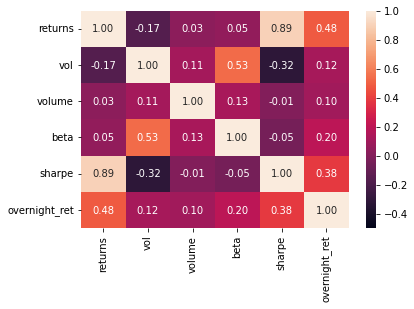

In [12]:
sns.heatmap(ann_data.corr(), annot=True, fmt='.2f', vmin=-0.5, vmax=1)
plt.show()

## dimension reduction

### pca

pca_data shape: (7102, 5)
explained var: [0.37650651 0.28052324 0.15741699 0.10159758 0.06920685]
singular values: [126.66371025 109.3327782   81.90148255  65.79723531  54.3050847 ]


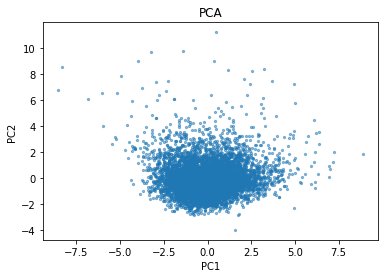

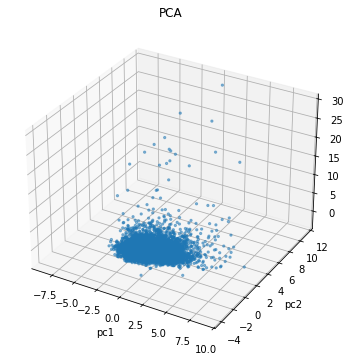

In [13]:
pca_data_ann = get_pca_data(ann_data, 5, show_plot=True, title='PCA')

pca_data shape: (491, 5)
explained var: [0.41321578 0.32785985 0.14553529 0.08243562 0.02185084]
singular values: [34.89030949 31.07853128 20.70620601 15.5838169   8.02325261]


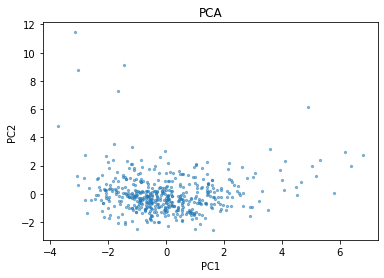

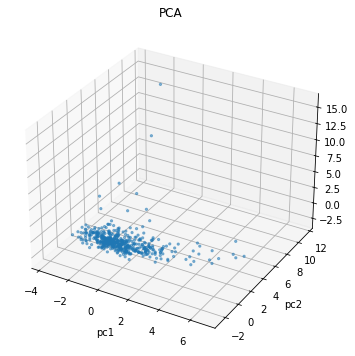

In [14]:
data_sample = ann_data[ann_data.index.get_level_values(0)==2020]
pca_data_sample = get_pca_data(data_sample, 5, show_plot=True, title='PCA')

### tsne

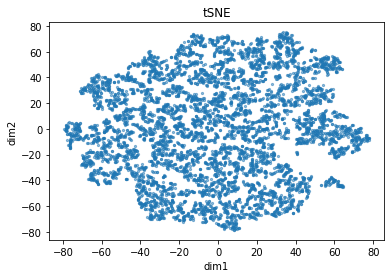

In [15]:
tsne_data_ann = get_tsne_data(
    ann_data, perplexity=30, n_components=2, scaled=True, 
    show_plot=True, title='tSNE'
)

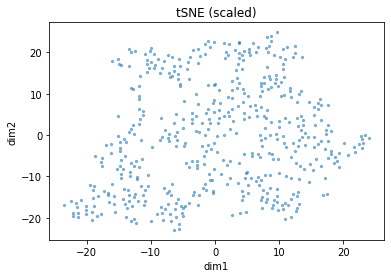

In [16]:
tsne_data_sample = get_tsne_data(
    data_sample, perplexity=30, n_components=2, scaled=True, 
    show_plot=True, title='tSNE (scaled)'
)

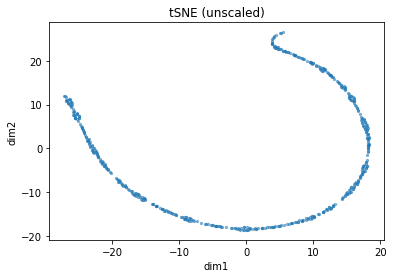

In [17]:
tsne_data_sample = get_tsne_data(
    data_sample, perplexity=30, n_components=2, scaled=False, 
    show_plot=True, title='tSNE (unscaled)'
)

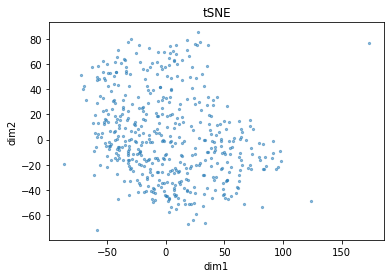

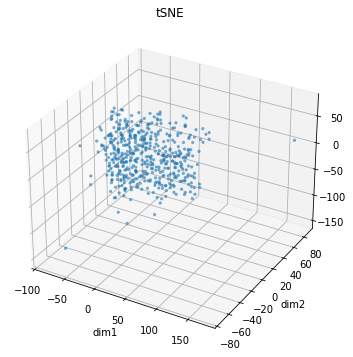

In [18]:
tsne_data_sample = get_tsne_data(
    data_sample, perplexity=30, n_components=3, scaled=True, 
    show_plot=True, title='tSNE'
)

In [19]:
data_sample.shape

(491, 6)

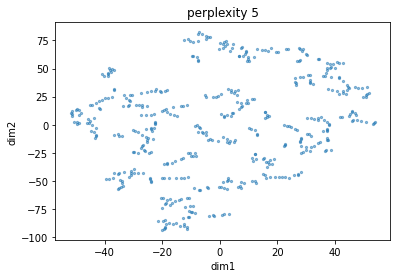

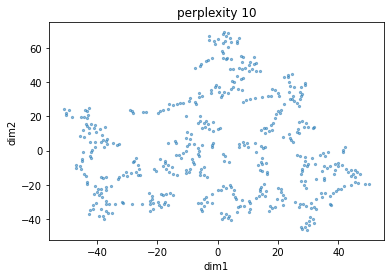

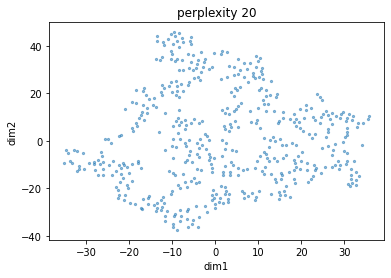

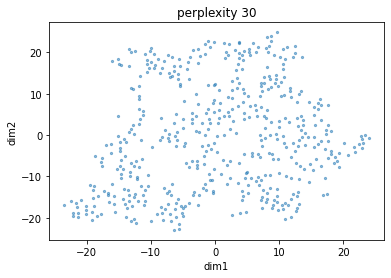

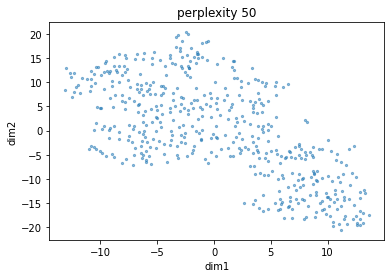

In [20]:
scaled_data = get_scaled_data(data_sample)
for p in [5, 10, 20, 30, 50]:
    tsne = TSNE(n_components=2, perplexity=p, random_state=seed)
    tsne_data = tsne.fit_transform(scaled_data)
    
    plt.scatter(tsne_data[:,0], tsne_data[:,1], alpha=0.5, s=5)
    plt.title(f"perplexity {p}")
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.show()

## kmeans

In [21]:
data_sample = ann_data[ann_data.index.get_level_values(0)==2020]
tsne_data = get_tsne_data(
    data_sample, perplexity=30, n_components=2, scaled=True, 
    show_plot=False
)

In [22]:
kmeans_scores = get_kmeans_score(tsne_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:04<00:00,  4.57it/s]


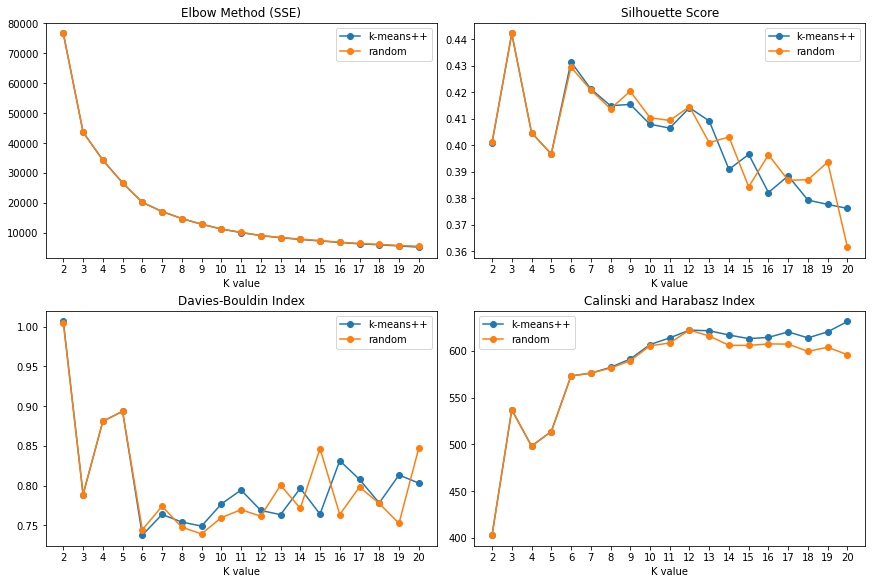

In [23]:
title_mapper = {
    'silhouette': 'Silhouette Score',
    'davies': 'Davies-Bouldin Index',
    'calinski': 'Calinski and Harabasz Index',
    'inertia': 'Elbow Method (SSE)'
}

f, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
x_range = range(2, 21)

for init in ['k-means++', 'random']:
    for a, m in enumerate(['inertia', 'silhouette', 'davies', 'calinski']):
        i = a // 2
        j = a % 2
        axes[i, j].plot(x_range, kmeans_scores[init][m], label=init, marker='o')
        axes[i, j].set_title(title_mapper[m])
        axes[i, j].legend()
        axes[i, j].set_xticks(x_range)
        axes[i, j].set_xlabel('K value')
    

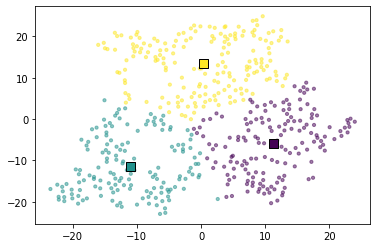

In [24]:
kmeans_opt = KMeans(n_clusters=3, random_state=seed).fit(tsne_data)
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=kmeans_opt.labels_, alpha=0.5, s=10)
plt.scatter(kmeans_opt.cluster_centers_[:,0], kmeans_opt.cluster_centers_[:,1], c=[0,1,2], s=80, edgecolors='black', linewidth=1, marker='s')
plt.show()

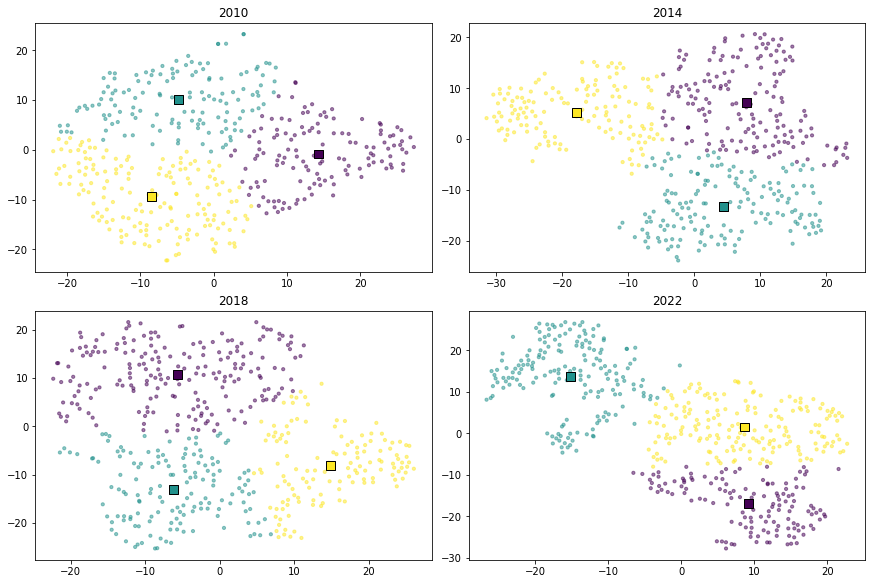

In [25]:
f, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
for a, year in enumerate([2010, 2014, 2018, 2022]):
    df_sample = ann_data[ann_data.index.get_level_values(0)==year]
    tsne_data = get_tsne_data(
        df_sample, perplexity=30, n_components=2, scaled=True, 
        show_plot=False
    )
    kmeans_opt = KMeans(n_clusters=3, random_state=seed).fit(tsne_data)
    i = a // 2
    j = a % 2
    axes[i, j].scatter(tsne_data[:,0], tsne_data[:,1], c=kmeans_opt.labels_, alpha=0.5, s=10)
    axes[i, j].scatter(kmeans_opt.cluster_centers_[:,0], kmeans_opt.cluster_centers_[:,1], c=[0,1,2], marker='s', s=80, edgecolors='black', linewidth=1)
    axes[i, j].set_title(f"{year}")

## gmm

In [26]:
from sklearn.mixture import GaussianMixture
import time

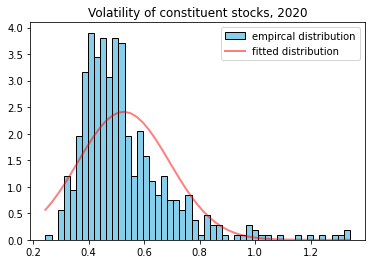

In [27]:
target = data_sample.vol
mu = target.mean()
sigma = target.std()

count, bins, _ = plt.hist(
    target, bins=50, density=True, color='skyblue', edgecolor='black',
    label='empircal distribution'
)
plt.plot(
    bins, 
    1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
    linewidth=2, color='r', alpha=0.5,
    label='fitted distribution'
)
plt.title('Volatility of constituent stocks, 2020')
plt.legend()
plt.show()

In [28]:
gmm_scores_set = get_gmm_score(tsne_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.16it/s]


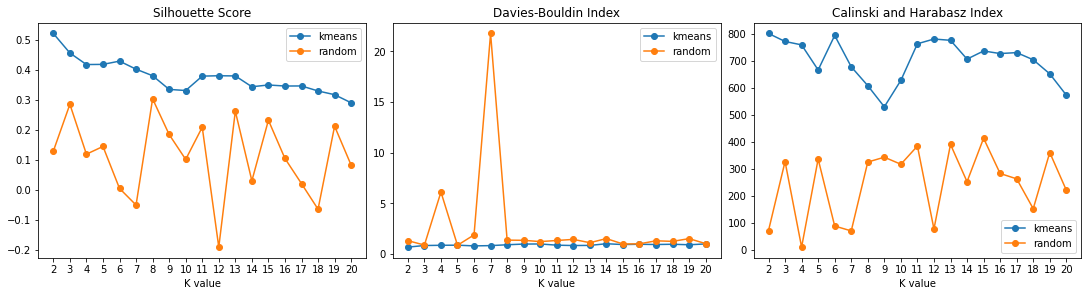

In [29]:
plot_gmm_score(gmm_scores_set)

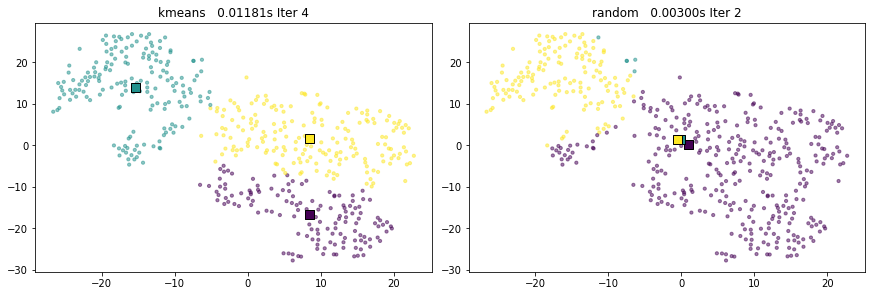

In [30]:
compare_init_methods(tsne_data)

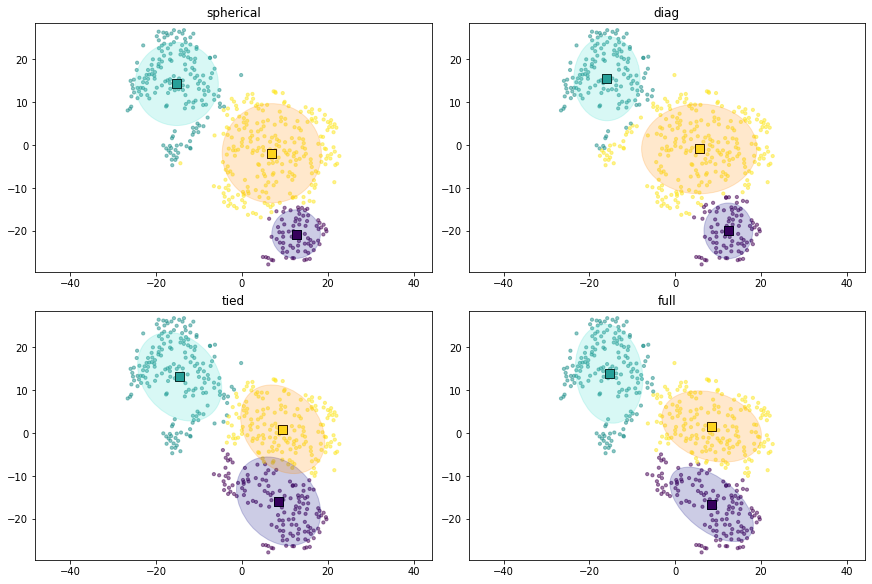

In [31]:
compare_cov_methods(tsne_data)

In [32]:
gmm_scores1 = get_gmm_score(tsne_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 12.64it/s]


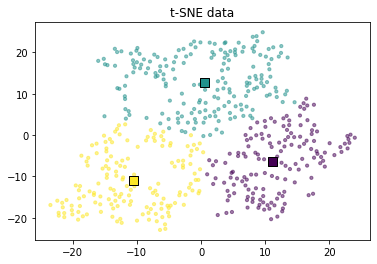

In [33]:
tsne_data = get_tsne_data(
    data_sample, perplexity=30, n_components=2, scaled=True, 
    show_plot=False
)
gmm = GaussianMixture(n_components=3)
y_pred = gmm.fit_predict(tsne_data)
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=y_pred, alpha=0.5, s=10, cmap='viridis')
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c=[0,1,2], marker='s', s=80, edgecolors='black', linewidth=1)
plt.title('t-SNE data')
plt.show()

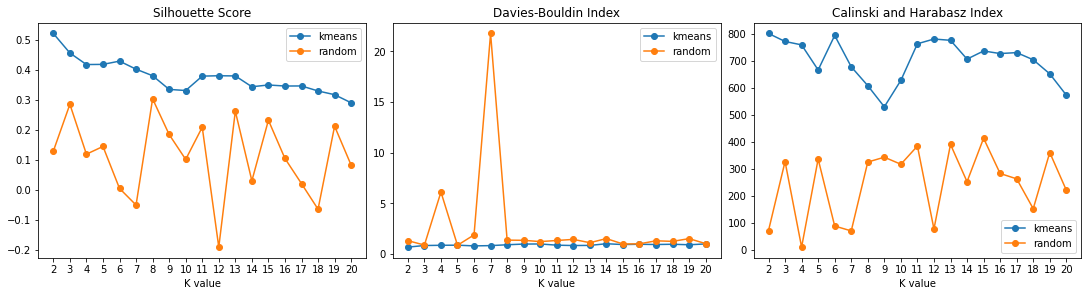

In [34]:
plot_gmm_score(gmm_scores1)

In [35]:
gmm_scores2 = get_gmm_score(data_sample)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  4.95it/s]


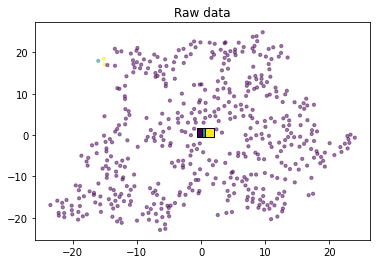

In [36]:
gmm = GaussianMixture(n_components=3)
y_pred = gmm.fit_predict(data_sample)
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=y_pred, alpha=0.5, s=10, cmap='viridis')
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c=[0,1,2], marker='s', s=80, edgecolors='black', linewidth=1)
plt.title('Raw data')
plt.show()

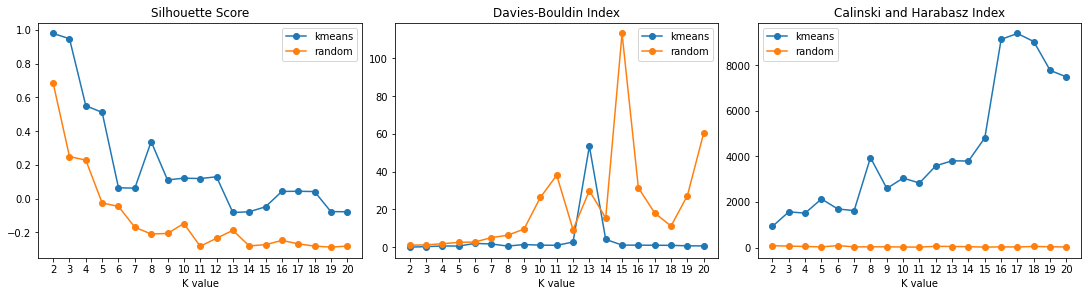

In [37]:
plot_gmm_score(gmm_scores2)

In [38]:
scaled_data = get_scaled_data(data_sample)
gmm_scores3 = get_gmm_score(scaled_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:03<00:00,  5.52it/s]


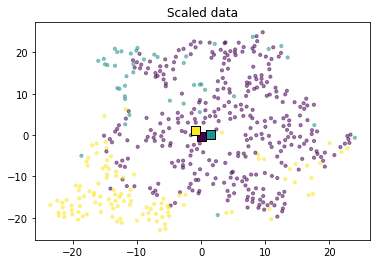

In [39]:
n = 3
gmm = GaussianMixture(n_components=n)
y_pred = gmm.fit_predict(scaled_data)
plt.scatter(tsne_data[:,0], tsne_data[:,1], c=y_pred, alpha=0.5, s=10, cmap='viridis')
plt.scatter(gmm.means_[:,0], gmm.means_[:,1], c=[i for i in range(n)], marker='s', s=80, edgecolors='black', linewidth=1)
plt.title('Scaled data')
plt.show()

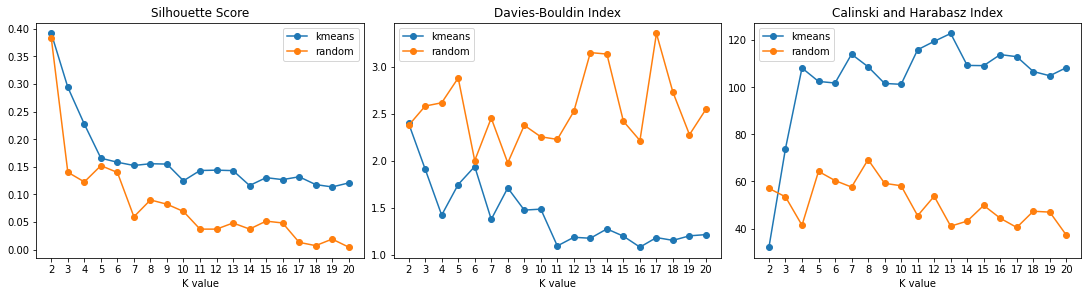

In [40]:
plot_gmm_score(gmm_scores3)

## comparison between kmeans and gmm

In [41]:
def compare_cluster_algo(data, show_plot=False):
    measures = ['silhouette', 'davies', 'calinski']
    m_func = [silhouette_score, davies_bouldin_score, calinski_harabasz_score]
    algos = ['kmeans', 'gmm']
    
    results = pd.DataFrame(index=algos, columns=measures)
    kmeans = KMeans(n_clusters=3, random_state=seed).fit(data)
    k_labels = kmeans.labels_
    gmm = GaussianMixture(n_components=3, init_params='kmeans', random_state=seed, covariance_type='full')
    g_labels = gmm.fit_predict(data)
    
    for (m, f) in zip(measures, m_func):
        for a in algos:
            if a == 'kmeans':
                b = k_labels
            else:
                b = g_labels
            results.loc[a, m] = f(data, b)
    
    if show_plot:
        f, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
        axes[0].scatter(data[:,0], data[:,1], c=k_labels, alpha=0.5, s=10, cmap='viridis')
        axes[0].scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=[0,1,2], s=80, edgecolors='black', linewidth=1, marker='s')
        axes[0].set_title('kmeans')
        axes[1].scatter(data[:,0], data[:,1], c=g_labels, alpha=0.5, s=10, cmap='viridis')
        axes[1].scatter(gmm.means_[:,0], gmm.means_[:,1], c=[0,1,2], marker='s', s=80, edgecolors='black', linewidth=1)
        axes[1].set_title('gmm')
                        
    return results

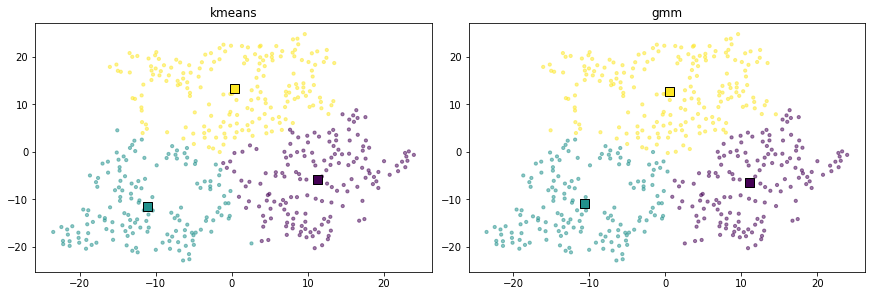

In [42]:
results = compare_cluster_algo(tsne_data, show_plot=True)

In [43]:
results

,silhouette,davies,calinski
kmeans,0.442191,0.788833,536.973057
gmm,0.442557,0.775558,530.758568


## eval

In [184]:
kmeans = KMeans(n_clusters=3, random_state=seed).fit(tsne_data)
k_labels = kmeans.labels_
gmm = GaussianMixture(n_components=3, init_params='kmeans', random_state=seed, covariance_type='full')
g_labels = gmm.fit_predict(tsne_data)

t_k = data_sample.copy()
t_k['group'] = k_labels.astype(str)
t_k = t_k.reset_index().rename(columns={'level_1': 'name'})
t_g = data_sample.copy()
t_g['group'] = g_labels.astype(str)
t_g = t_g.reset_index().rename(columns={'level_1': 'name'})


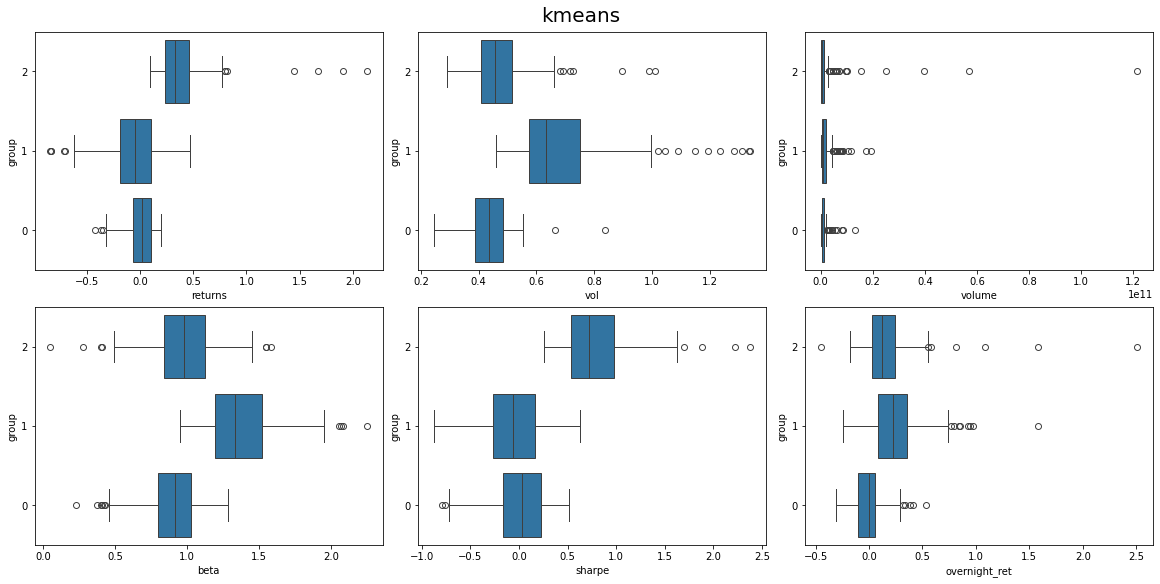

In [189]:
features = ['returns', 'vol', 'volume', 'beta', 'sharpe', 'overnight_ret']
f, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
plt.suptitle('kmeans', fontsize=20)
for a in range(len(features)):
    i = a // 3
    j = a % 3
    sns.boxplot(data=t_k, x=features[a], y='group', ax=axes[i,j])

<Axes: xlabel='returns', ylabel='vol'>

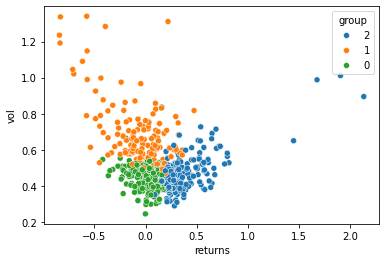

In [192]:
sns.scatterplot(data=t_k, x='returns', y='vol', hue='group')

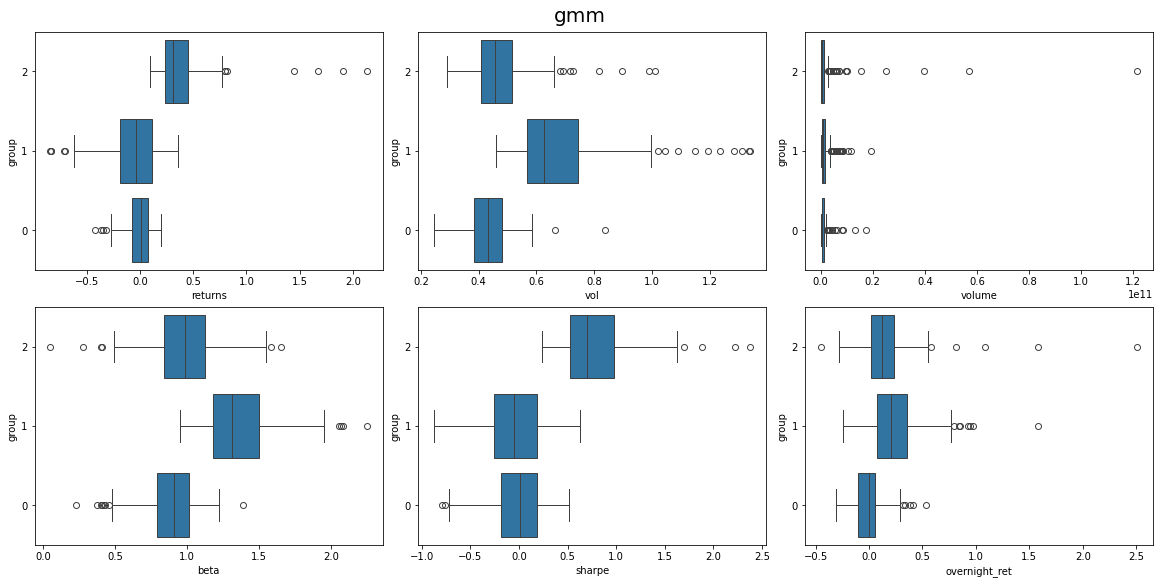

In [190]:
features = ['returns', 'vol', 'volume', 'beta', 'sharpe', 'overnight_ret']
f, axes = plt.subplots(2, 3, figsize=(16, 8), constrained_layout=True)
plt.suptitle('gmm', fontsize=20)
for a in range(len(features)):
    i = a // 3
    j = a % 3
    sns.boxplot(data=t_g, x=features[a], y='group', ax=axes[i,j])

Text(0.5, 1.0, '2020 plot of returns vs volatility')

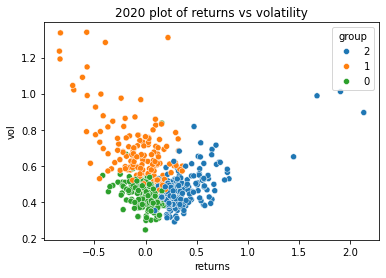

In [199]:
sns.scatterplot(data=t_g, x='returns', y='vol', hue='group')
plt.title('2020 plot of returns vs volatility')

## monthly eval

In [44]:
mth_returns = returns.groupby([returns.index.year, returns.index.month]).sum(min_count=1)
mth_vol = returns.groupby([returns.index.year, returns.index.month]).std() * np.sqrt(21)
mth_volumes = volumes.groupby([volumes.index.year, volumes.index.month]).sum(min_count=1)
mth_sharpe = mth_returns / mth_vol
mth_overnight = overnight.groupby([overnight.index.year, overnight.index.month]).sum(min_count=1)
mth_betas = data.groupby([data.index.year, data.index.month]).apply(apply_beta_per_year).drop(columns=['spx'])
# mth_excess_returns = mth_returns.sub(mth_returns.mean(axis=1), axis=0)

In [45]:
mth_data = pd.concat([
    mth_returns.stack(),
    mth_vol.stack(),
    mth_volumes.stack(), 
    mth_betas.stack(),
    mth_sharpe.stack(),
    mth_overnight.stack(),
#     mth_excess_returns.stack()
], axis=1).dropna()
mth_data.columns = ['returns', 'vol', 'volume', 'beta', 'sharpe', 'overnight']

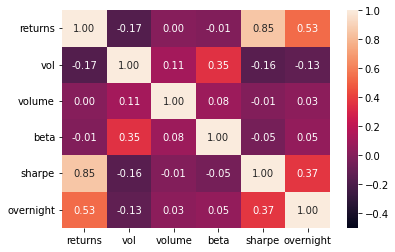

In [46]:
sns.heatmap(mth_data.corr(), annot=True, fmt='.2f', vmin=-0.5, vmax=1)
plt.show()

In [48]:
pd.concat([
    pd.concat([results], keys=[pd.to_datetime(f'2010-5-01')]),
    pd.concat([results], keys=[pd.to_datetime(f'2010-6-01')])
], axis=0)

silhouette    davies    calinski
2010-05-01 kmeans   0.442191  0.788833  536.973057
           gmm      0.442557  0.775558  530.758568
2010-06-01 kmeans   0.442191  0.788833  536.973057
           gmm      0.442557  0.775558  530.758568

In [49]:
def compare_many_months_algo(mth_data):
    master_results = pd.DataFrame()
    for year in range(2010, 2025):
        for month in range(1, 13):
            df_subset = mth_data[
                (mth_data.index.get_level_values(0) == year)
                & (mth_data.index.get_level_values(1) == month)
            ]
            if len(df_subset) == 0:
                continue
                
            scaled_data = get_scaled_data(df_subset)
            tsne = TSNE(n_components=2, perplexity=30, random_state=seed)
            tsne_data = tsne.fit_transform(scaled_data)
            
            results = compare_cluster_algo(tsne_data, show_plot=False)
            master_results = pd.concat([
                master_results, 
                pd.concat([results], keys=[pd.to_datetime(f'{year}-{month}-01',)])
            ], axis=0)
    return master_results

In [50]:
master_results = compare_many_months_algo(mth_data)

In [58]:
master_results.groupby(master_results.index.get_level_values(1)).mean()

,silhouette,davies,calinski
gmm,0.409514,0.863662,514.986032
kmeans,0.421208,0.851945,554.310755


In [73]:
k_results = master_results[master_results.index.get_level_values(1)=='kmeans'].droplevel(1, axis=0)
g_results = master_results[master_results.index.get_level_values(1)=='gmm'].droplevel(1, axis=0)

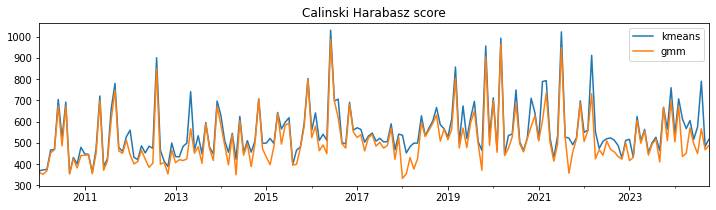

In [81]:
f = plt.figure(figsize=(12,3))
k_results.calinski.plot(label='kmeans')
g_results.calinski.plot(label='gmm')
plt.legend()
plt.title('Calinski Harabasz score')
plt.show()

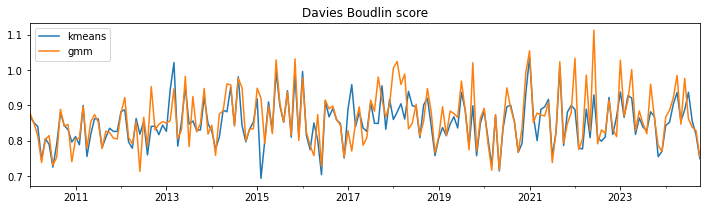

In [82]:
f = plt.figure(figsize=(12,3))
k_results.davies.plot(label='kmeans')
g_results.davies.plot(label='gmm')
plt.title('Davies Boudlin score')
plt.legend()
plt.show()

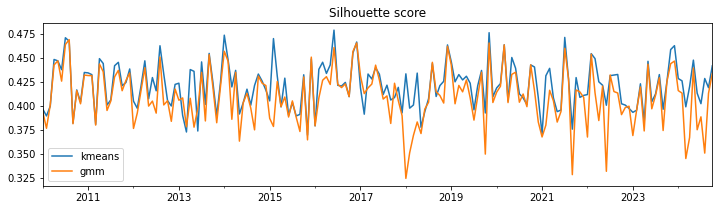

In [83]:
f = plt.figure(figsize=(12,3))
k_results.silhouette.plot(label='kmeans')
g_results.silhouette.plot(label='gmm')
plt.title('Silhouette score')
plt.legend()
plt.show()

## naive portfolio strategy
- in month (n+1), choose the stocks from month (n)
- for each month, assume the weights of all constituents are equally distributed

In [196]:
def test_portfolio(mth_data, model='k', k=3):
    df_labels = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], codes=[[], []]), columns=mth_returns.columns)
    df_best_label = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], codes=[[], []]), columns=[])

    for year in range(2010, 2025):
        for month in range(1, 13):

            df_subset = mth_data[
                (mth_data.index.get_level_values(0) == year)
                & (mth_data.index.get_level_values(1) == month)
            ]
            if len(df_subset) == 0:
                continue

            scaled_data = get_scaled_data(df_subset)
            tsne = TSNE(n_components=2, perplexity=30, random_state=seed)
            tsne_data = tsne.fit_transform(scaled_data)
            
            if model=='k':
                kmeans = KMeans(n_clusters=k, random_state=seed).fit(tsne_data)
                labels = kmeans.labels_
            elif model=='g':
                gmm = GaussianMixture(n_components=k, init_params='kmeans', random_state=seed, covariance_type='full')
                labels = gmm.fit_predict(tsne_data)

            df_subset['label'] = labels.astype(str)

            df_labels = pd.concat([df_labels, df_subset.label.unstack()], axis=0)
            df_best_label = pd.concat([
                df_best_label,
                pd.Series(index=[(year, month)], data=df_subset.groupby('label')['sharpe'].mean().idxmax())
            ], axis=0)
            
    df_returns = pd.DataFrame(index=pd.MultiIndex(levels=[[], []], codes=[[], []]), columns=['rets'])
    indices = df_labels.index
    for i, index in enumerate(indices[1:]):
        group = df_best_label.iloc[i-1, 0]
        row = df_labels.iloc[i-1,]
        filtered_stocks = row[row==group].index
        df_returns.loc[index, 'rets'] = mth_returns.loc[index, filtered_stocks].dropna().mean()
        
    return df_returns

In [197]:
df_plot = pd.concat([
    idx.groupby([idx.index.year, idx.index.month])['returns'].sum(),
    test_portfolio(mth_data, 'k', 3)['rets'].astype(float),
    test_portfolio(mth_data, 'g', 3)['rets'].astype(float)
], axis=1)
df_plot.columns = ['index', 'kmeans', 'gmm']
df_plot.iloc[0,:] = [0.0, 0.0, 0.0]

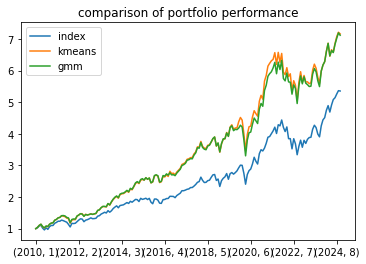

In [200]:
np.exp(df_plot).cumprod().plot()
plt.title('comparison of portfolio performance')
plt.show()

In [201]:
np.exp(df_plot).cumprod().iloc[-1,]

index     5.355462
kmeans    7.163155
gmm       7.120465
Name: (2024, 10), dtype: float64